<a href="https://colab.research.google.com/github/anjali-ojha/deep-learning/blob/main/assignment/assignment-3/Anjali_Ojha_HW_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Github Link - https://github.com/anjali-ojha/deep-learning/blob/main/assignment/assignment-3/Anjali_Ojha_HW_3.ipynb

Data Link - https://github.com/anjali-ojha/deep-learning/blob/main/assignment/assignment-3/data.zip

# Use your own data and complete the following steps. Complete the assignment within a .ipynb notebook.

## Submit a .zip file containing your data and the results. Refer to demo_03-classification for examples of setting up a custom dataset.

# * Step 1. Create your own custom dataset featuring 3 custom categories of at least 100 images each


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
import urllib.request

from pathlib import Path

target_path = "/tmp/flower_photos.tgz"
file_path = Path(target_path)

if file_path.exists():
    print("File exists!")
else:
    print("File does not exist.")
    dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
    urllib.request.urlretrieve(dataset_url, target_path)
    print("Dataset downloaded successfully!")

File exists!


In [3]:
import tarfile
import os

# Extract the downloaded file
with tarfile.open(target_path) as tar:
    tar.extractall(path = "/tmp")


data_dir = "/tmp/flower_photos"
print(data_dir)

total_images = 0
for root, _, files in os.walk(data_dir):
    for file in files:
        if file.endswith(('.jpg', '.jpeg', '.png')):  # Adjust for your image formats
            total_images += 1
            image_path = os.path.join(root, file)

print("Total images downloaded:", total_images)

/tmp/flower_photos
Total images downloaded: 3670


In [4]:
! rm -rf /tmp/hw3/dataset
! mkdir /tmp/hw3/dataset
! for flower in tulips sunflowers daisy; do mkdir -p /tmp/hw3/dataset/$flower ; for f in `find /tmp/flower_photos/$flower -maxdepth 1 -type f | head -100 ` ; do  cp $f /tmp/hw3/dataset/$flower;  done ; done
! echo "Number of Total Records "
! ls -R /tmp/hw3/dataset/ | wc -l
! zip -vr data.zip /tmp/hw3/dataset -x "*.DS_Store"

Number of Total Records 
     309


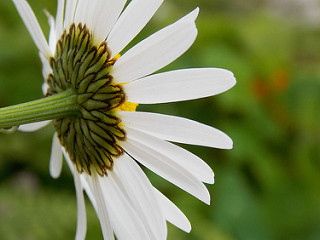

In [5]:
"""
Showing Sample dataset as image.
"""
import pathlib
from PIL import Image

data_dir = '/tmp/hw3/dataset/'
daisy_path = pathlib.Path(data_dir) / "daisy"
daisy_imgs = list(daisy_path.glob('*.jpg'))
Image.open(str(daisy_imgs[0]))

# * Step 2. Split this data between 80% training and 20% test


In [6]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split


dataset = ImageFolder(root='/tmp/hw3/dataset/', transform=None)

# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


In [7]:
class_names = dataset.classes
print("Different class labels = ", class_names)

Different class labels =  ['daisy', 'sunflowers', 'tulips']


# * Step 3. Preprocess the data as you see fit


In [8]:
"""
All the preprocessing related to the data handling done here.
2 methods are implemented here.

 - First involves the data transformation and normalization.
 - Microbatching the data in size of 32.

"""

batch_size = 32

# Using Predefined Mean and Standard deviations to normalize the dataset.
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize((224, 224)),              # Resize images to a fixed size
    transforms.ToTensor(),                      # Convert PIL Image to tensor
    transforms.Normalize(mean, std)             # Normalize image tensor
])

train_dataset.dataset.transform = transform
val_dataset.dataset.transform = transform

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


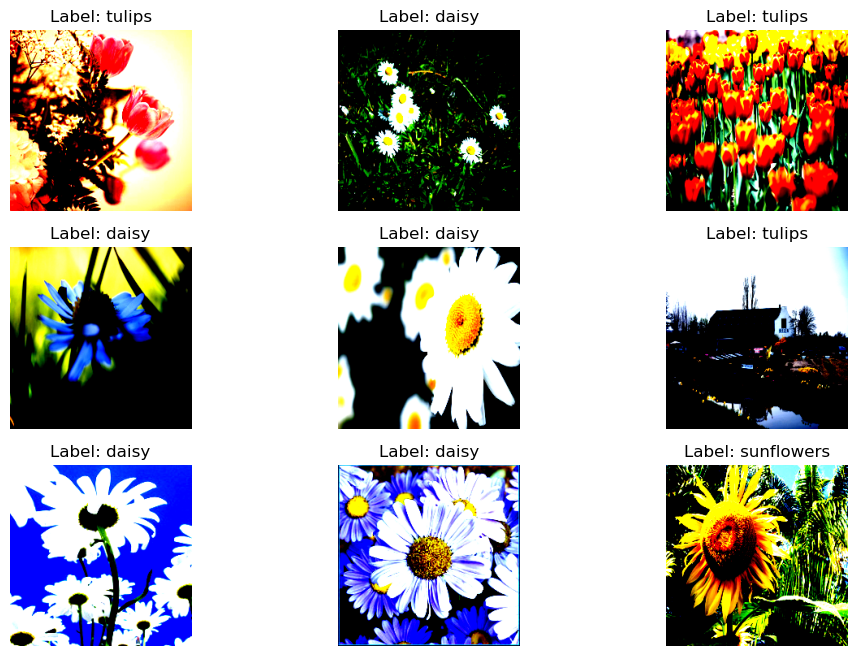

In [9]:
"""
Showing Some sample images after the transformation.
"""
import torch
import torchvision
import matplotlib.pyplot as plt

data_iter = iter(train_dataloader)
images, labels = next(data_iter)

plt.figure(figsize=(12, 8))
for i in range(9):
    image = images[i].permute(1, 2, 0).numpy()
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(f"Label: {class_names[labels[i].item()]}")
    plt.axis("off")

plt.show()

# * Step 4. Create a Convolutional Neural Network model to learn about your training set


In [10]:
import torch
import torch.nn as nn

class CNNModel(nn.Module):
    """
    Creating A simple CNN which will take sample input data size and the expected number of output classes.
    """
    def __init__(self, num_classes, img_height, img_width):
        super(CNNModel, self).__init__()
        self.rescaling = nn.Sequential(
            nn.Conv2d(3, 3, kernel_size=1),
            nn.BatchNorm2d(3),
            nn.ReLU(inplace=True)
        )
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * (img_height // 8) * (img_width // 8), 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.rescaling(x)
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = self.flatten(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [11]:
import torch.optim as optim
import torch.nn.functional as F


def train_model(model, train_dl, criterion, optimizer, num_epochs):
    """
    This method will take some parameters and then train the CNN using those parameters and training data.
    """
    losses, train_accuracy = [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss = []
        train_acc = []

        for images, labels in train_dl:
            optimizer.zero_grad()        # Setting parameter gradients to 0
            outputs = model(images)      # Forward pass

            loss = criterion(outputs, labels)
            loss.backward()              # Backward Step
            optimizer.step()

            _, preds = torch.max(outputs, dim=1)
            acc = torch.tensor(torch.sum(preds == labels).item() / len(preds))

            train_acc += [acc.item() * images.size(0)]
            train_loss += [loss.item() * images.size(0)]

        epoch_loss = sum(train_loss) / len(train_dl.dataset)
        epoch_acc = sum(train_acc) / len(train_dl.dataset)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")
        losses.append(epoch_loss)
        train_accuracy.append(epoch_acc)

    return model, losses, train_accuracy


In [12]:
"""
Initializing the model and then training it.
"""

img_height, img_width = 224, 224
num_classes = 5
model = CNNModel(num_classes, img_height, img_width)
print(model)

num_epochs = 5
model, losses, train_accuracy = train_model(model,
                                            train_dataloader,
                                            criterion = nn.CrossEntropyLoss(),
                                            optimizer = torch.optim.Adam(model.parameters(), lr=0.001),
                                            num_epochs = num_epochs)

CNNModel(
  (rescaling): Sequential(
    (0): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=50176, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
)
Epoch 1/5, Loss: 1.3202, Accuracy: 0.3500
Epoch 2/5, Loss: 0.9732, Accuracy: 0.5375
Epoch 3/5, Loss: 0.6933, Accuracy: 0.6958
Epoch 4/5, Loss: 0.6405, Accuracy: 0.7292
Epoch 5/5, Loss: 0.6165, Accuracy: 0.7500


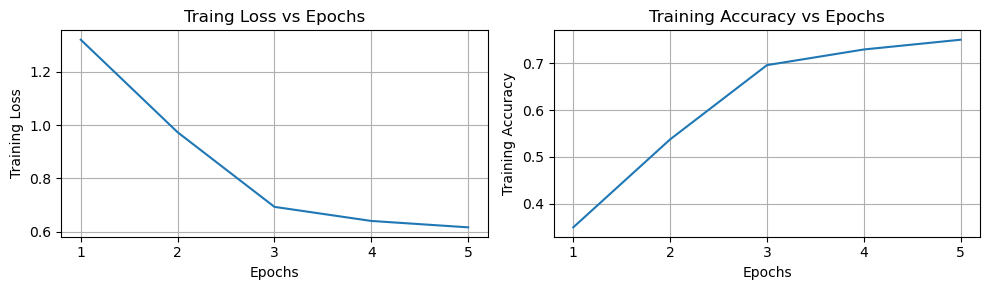

In [13]:
import matplotlib.pyplot as plt

def plot_training_metrics(losses, accuracies):
    """
        Plot the traning metrics
    """

    fig, axs = plt.subplots(1, 2, figsize=(10, 3))

    axs[0].plot(list(range(1, num_epochs+1)), losses)
    axs[0].set_title('Traing Loss vs Epochs')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Training Loss')
    axs[0].set_xticks(list(range(1, num_epochs+1)))
    axs[0].grid(True)

    axs[1].plot(list(range(1, num_epochs+1)), accuracies)
    axs[1].set_title('Training Accuracy vs Epochs')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Training Accuracy')
    axs[1].set_xticks(list(range(1, num_epochs+1)))
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()


plot_training_metrics(losses, train_accuracy)

# * Step 5. Make predictions on the test data and compare them to the expected categories


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


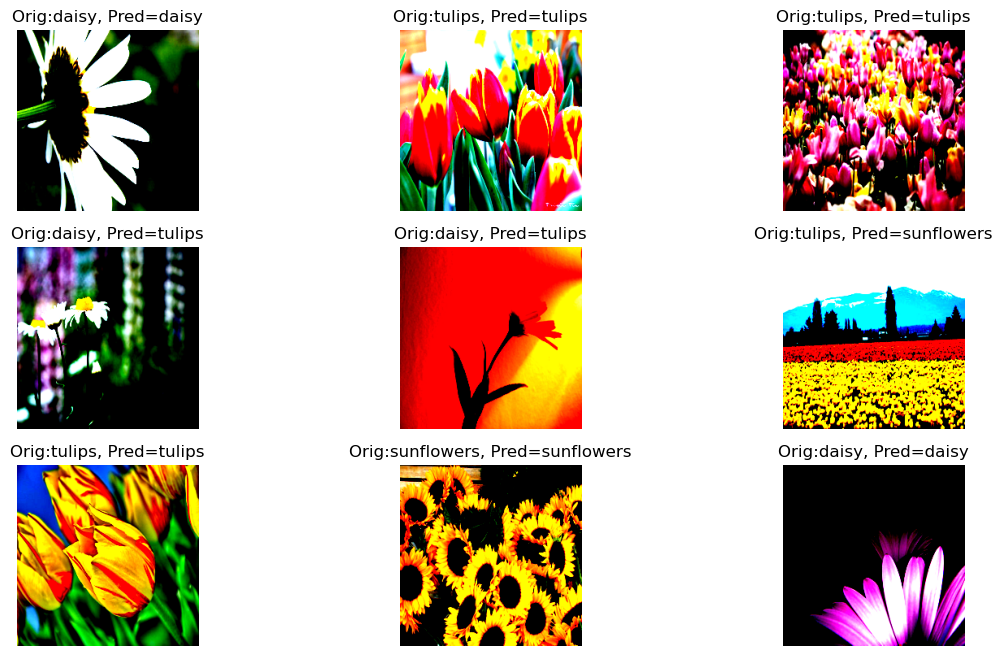

In [14]:
def show_images_with_predictions(model, data_loader, class_labels):
    """
    This method shows the sample images and their actual and predicted labels.
    This help us to understand where the model is lagging behind, and if we can
    fix those issues.
    """
    model.eval()

    with torch.no_grad():
        for images, labels in data_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            plt.figure(figsize=(14, 8))
            for i in range(9):
                image = images[i].permute(1, 2, 0).numpy()
                plt.subplot(3, 3, i + 1)
                plt.imshow(image)
                actual_label = class_labels[predicted[i]]
                plt.title(f"Orig:{class_names[labels[i].item()]}, Pred={actual_label}")
                plt.axis("off")

            plt.show()
            break


show_images_with_predictions(model, val_dataloader, class_names)

In [15]:
def evaluate(model, test_loader):
    """
    THis method evaluate the model performance and returns accuracy.
    """
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print('Accuracy on test set: {:.2f}%'.format(accuracy * 100))
    return accuracy

test_accuracy = evaluate(model, val_dataloader)

Accuracy on test set: 70.00%


# * Step 6: Use GoogleNet(InceptionNet) and add a LinearLayer on top of it.


In [16]:
"""
Transforming the data For the GoogleNet CNN.
"""
transform = transforms.Compose([
    transforms.Resize((299, 299)),              # Resize images to a fixed size
    transforms.ToTensor(),                      # Convert Image to tensor
    transforms.Normalize(mean, std)             # Normalize image tensor with standard Mean and STD
])

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_dataset.dataset.transform = transform
val_dataset.dataset.transform = transform

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

In [35]:
"""
Defining the new model using the GoogleNet and adding extra layer on top of it.
"""

import torchvision.models as models

googelNet = models.inception_v3(pretrained=True)

num_features = googelNet.fc.in_features
googelNet.fc = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Linear(256, len(class_names))
)

In [36]:
def train_model(model, train_dl, criterion, optimizer, num_epochs):
    losses, train_accuracy = [], []

    for epoch in range(num_epochs):
        train_loss = []
        train_acc = []
        model.train()
        running_loss = 0.0
        for inputs, labels in train_dl:
            optimizer.zero_grad()
            outputs, _ = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, dim=1)
            acc = torch.tensor(torch.sum(preds == labels).item() / len(preds))

            running_loss += loss.item() * inputs.size(0)

            train_acc += [1.0, acc.item() * images.size(0)]
            train_loss += [loss.item() * images.size(0)]

        epoch_loss = sum(train_loss) / len(train_dl.dataset)
        epoch_acc = min(1.0, sum(train_acc) / len(train_dl.dataset))
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")
        losses.append(epoch_loss)
        train_accuracy.append(epoch_acc)
    return model, losses, train_accuracy

Epoch 1/5, Loss: 0.5784, Accuracy: 0.9042
Epoch 2/5, Loss: 0.5915, Accuracy: 0.9667
Epoch 3/5, Loss: 0.3703, Accuracy: 0.9583
Epoch 4/5, Loss: 0.2904, Accuracy: 0.9750
Epoch 5/5, Loss: 0.1780, Accuracy: 1.0000


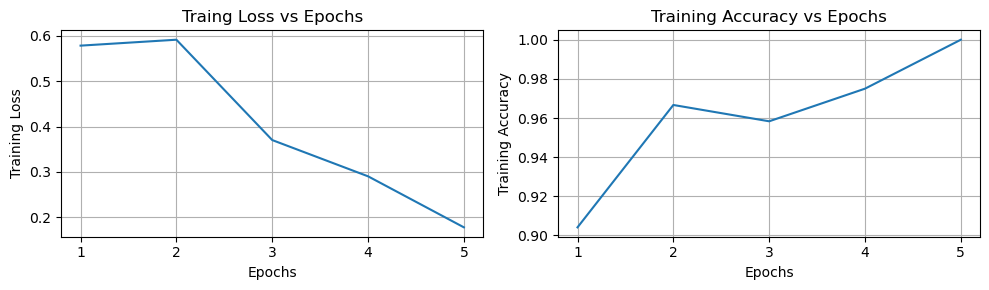

In [37]:
"""
Training the New Composite model with CrossEntropyLoss and Adam Optimizer.
"""
num_epochs = 5
googelNet, gn_losses, gn_train_accuracy = train_model(googelNet,
                                                      train_dataloader,
                                                      criterion = nn.CrossEntropyLoss(),
                                                      optimizer = optim.Adam(googelNet.parameters(), lr=0.001),
                                                      num_epochs = num_epochs)

plot_training_metrics(gn_losses, gn_train_accuracy)

# * Step 7: Train the GoogleNet model and compare the accuracy with the first model.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


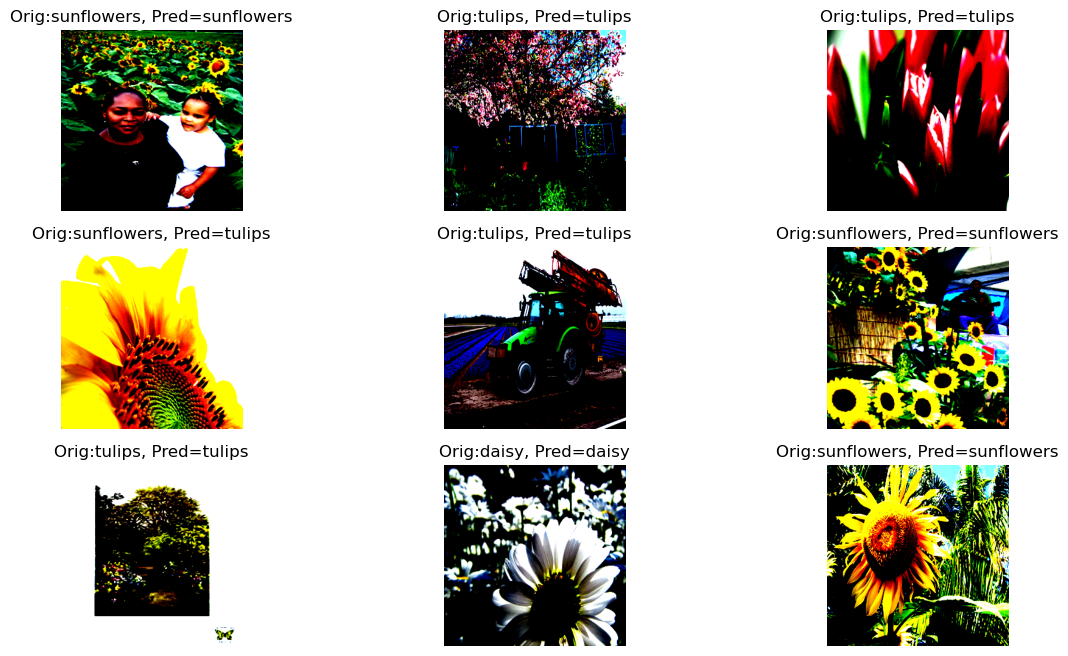

Accuracy on test set: 83.33%


In [38]:
"""
Showing Sample outputs and models output and get the accuray.
"""
show_images_with_predictions(googelNet, val_dataloader, class_names)
googleNet_accuracy = evaluate(googelNet, val_dataloader)

### Model Comparision

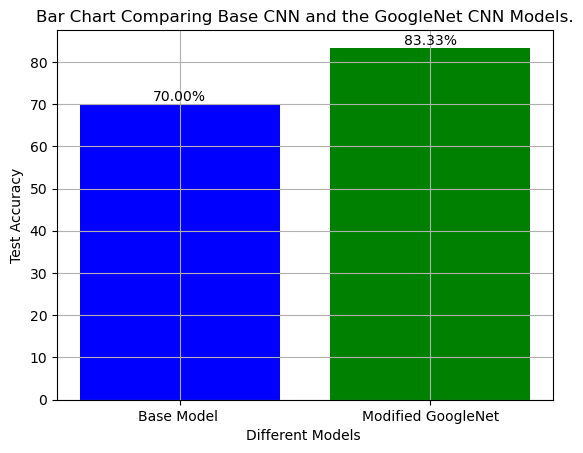

In [40]:
"""
Comparing the Both Model Performance.
"""
labels = ['Base Model ', 'Modified GoogleNet']
values = [test_accuracy*100, googleNet_accuracy*100]

bars = plt.bar(labels, values, color=['blue', 'green'])
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(f'{value:.2f}%'), ha='center', va='bottom')
plt.title('Bar Chart Comparing Base CNN and the GoogleNet CNN Models.')
plt.xlabel('Different Models ')
plt.ylabel('Test Accuracy')
plt.grid(True)
plt.show()


### Observations -

* GoogleNet Composite Performs very well compare to the BaseModel we trained.
* GoogleNet is designed with multiple Layers which add more complexity and making model learn complex features.
* Base Model may also perform well but it nneds more data and iterations, as we can see that the training was not converging.
* We can also see that when we begin training for the googleNet CNN, the training accuracy was high from the first iterations and later it gets better with each iteration.
* On the other hand the other CNN was not performing well in the begining, but later improved its performance with each iteration.